In [1]:
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
np.array(50*[np.random.random((150,150,1))]).shape

(50, 150, 150, 1)

# without BN model

In [169]:
from keras.models import load_model
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.engine import Layer
from keras.applications.vgg16 import *
from keras.models import *
import keras.backend as K
import tensorflow as tf

def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
    '''Resizes the images contained in a 4D tensor of shape
    - [batch, channels, height, width] (for 'channels_first' data_format)
    - [batch, height, width, channels] (for 'channels_last' data_format)
    by a factor of (height_factor, width_factor). Both factors should be
    positive integers.
    '''
    if data_format == 'default':
        data_format = K.image_data_format()
    if data_format == 'channels_first':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[2:]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = permute_dimensions(X, [0, 2, 3, 1])
        X = tf.image.resize_bilinear(X, new_shape)
        X = permute_dimensions(X, [0, 3, 1, 2])
        if target_height and target_width:
            X.set_shape((None, None, target_height, target_width))
        else:
            X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
        return X
    elif data_format == 'channels_last':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[1:3]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = tf.image.resize_bilinear(X, new_shape)
        if target_height and target_width:
            X.set_shape((None, target_height, target_width, None))
        else:
            X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
        return X
    else:
        raise Exception('Invalid data_format: ' + data_format)

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.data_format == 'channels_last':
            width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
            height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid data_format: ' + self.data_format)

    def call(self, x, mask=None):
        if self.target_size is not None:
            return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
        else:
            return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

    def get_config(self):
        config = {'size': self.size, 'target_size': self.target_size}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
weight_decay = 0.
classes = 1
input_shape = (150,150,1)
img_input = Input(shape=input_shape)
image_size = input_shape[0:2]

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid',name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block4_pool')(x)


# Convolutional layers transfered from fully-connected layers
x = Conv2D(4096, (5, 5), activation='relu', padding='same', kernel_initializer='he_normal',name='fc1', kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
x = Conv2D(2048, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal',name='fc2', kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
#classifying layer
x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

x = BilinearUpSampling2D(size=(16, 16))(x)

x = Conv2D(classes, (1, 1), activation='linear',
               padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(weight_decay),
               use_bias=False)(x)


row, col, channel = input_shape

# TODO(ahundt) this is modified for the sigmoid case! also use loss_shape
x = Reshape((-1,))(x)
#x = Flatten()(x)
model = Model(img_input, x)

In [170]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
model.load_weights('D:\\lizenan\\weights_epoch=32-val_loss=0.0587.hdf5')

In [39]:
input_X = cv2.imread('D:\\lizenan\\test\\017.png', cv2.IMREAD_GRAYSCALE)

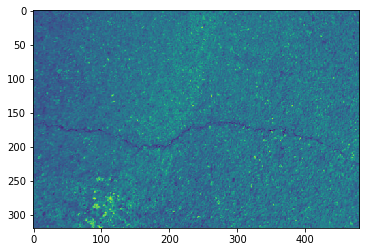

In [40]:
plt.imshow(input_X)

In [54]:
np.where((input_X>0)&(input_X<255))
input_X = input_X.astype(np.float32)
normalizedImg = np.zeros_like(input_X)

normalizedImg = cv2.normalize(input_X,  normalizedImg, 0, 1, cv2.NORM_MINMAX)

In [51]:
input_X.astype(np.float16)

array([[ 53.,  58.,  67., ...,  83.,  81.,  84.],
       [ 60.,  62.,  67., ...,  84.,  89.,  96.],
       [ 62.,  62.,  62., ...,  80.,  85.,  95.],
       ...,
       [ 85.,  75.,  74., ...,  94.,  96., 107.],
       [ 81.,  74.,  73., ..., 104.,  95., 107.],
       [ 67.,  69.,  72., ..., 104.,  94., 113.]], dtype=float16)

In [55]:
normalizedImg.dtype

dtype('float32')

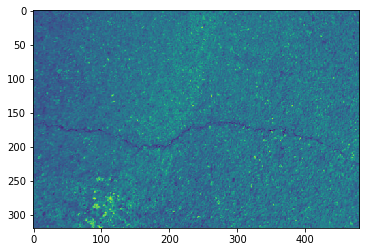

In [57]:
import matplotlib.pyplot as plt

plt.imshow(normalizedImg)
plt.show()

In [33]:
array_X = np.array(X).reshape(-1,150,150,1)

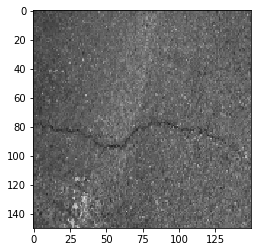

In [38]:
a = cv2.imread("D:\\lizenan\\test\\017.png")
a = cv2.resize(a,(150,150))
plt.imshow(a)

# BN model

In [171]:
weight_decay = 0.
classes = 1
input_shape = (150,150,1)
img_input = Input(shape=input_shape)
image_size = input_shape[0:2]

# Block 1
x = Conv2D(64, (3, 3), padding='same',kernel_initializer='he_normal', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid',name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3),  padding='same', kernel_initializer='he_normal',name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3),  padding='same', kernel_initializer='he_normal',name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block4_pool')(x)


# Convolutional layers transfered from fully-connected layers
x = Conv2D(4096, (5, 5), padding='same', kernel_initializer='he_normal',name='fc1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Conv2D(2048, (1, 1), padding='same', kernel_initializer='he_normal',name='fc2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
#classifying layer
x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('linear')(x)
x = BilinearUpSampling2D(size=(16, 16))(x)

x = Conv2D(classes, (1, 1),
               padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(weight_decay),
               use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('linear')(x)

row, col, channel = input_shape

# TODO(ahundt) this is modified for the sigmoid case! also use loss_shape
x = Reshape((-1,))(x)
#x = Flatten()(x)
model = Model(img_input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization_29 (Batc (None, 150, 150, 64)      256       
_________________________________________________________________
activation_29 (Activation)   (None, 150, 150, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_30 (Batc (None, 150, 150, 64)      256       
_________________________________________________________________
activation_30 (Activation)   (None, 150, 150, 64)      0         
__________

In [172]:
model.load_weights('D:\\lizenan\\weights_epoch=97-val_loss=0.07.hdf5')

In [16]:
import cv2
import glob
import numpy

test_pics = glob.glob('D:\\lizenan\\test\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]

In [17]:
array_X = np.array(X).reshape(-1,150,150,1)

In [21]:
fake_X =  array_X.reshape(-1,150,150)

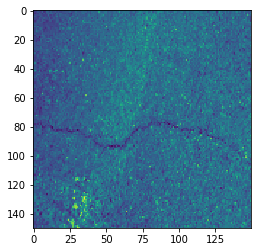

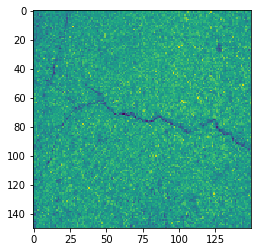

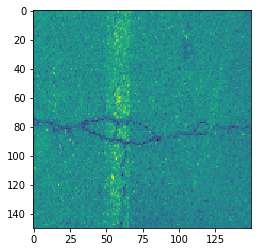

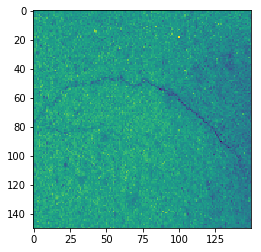

In [23]:
import matplotlib.pyplot as plt
for a in fake_X:
    plt.imshow(a)
    plt.show()

In [41]:
pred_y[3].max()

-0.22669463

In [42]:
pred_y[3].min()

-21.948414

In [56]:
batch_y1 = np.zeros_like(pred_y[0])
batch_y = cv2.normalize(pred_y[0],batch_y1,cv2.NORM_L2)#NORM_MINMAX

In [58]:
batch_y.max()

0.0014561403

In [63]:
mean = np.mean(pred_y[2])
std = np.std(pred_y[2])
y1 =  (pred_y[2] - mean) / std
y1.min(),y1.max()

(-3.3555987, 2.1527019)

In [64]:
mean = np.mean(pred_y[1])
std = np.std(pred_y[1])
y1 =  (pred_y[1] - mean) / std
y1.min(),y1.max()

(-3.331049, 2.0647478)

In [65]:
mean = np.mean(pred_y[0])
std = np.std(pred_y[0])
y1 =  (pred_y[0] - mean) / std
y1.min(),y1.max()

(-3.2311084, 2.0911283)

In [ ]:
mean = np.mean(pred_y[3])
std = np.std(pred_y[3])
y1 =  (pred_y[3] - mean) / std
y1.min(),y1.max()

# Test data

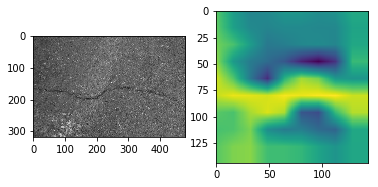

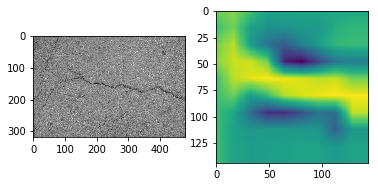

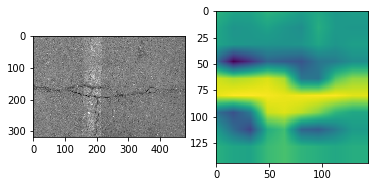

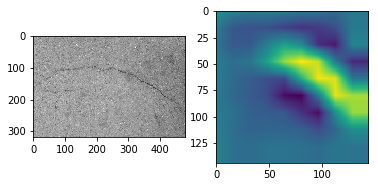

In [59]:
pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\test\\*')

for y,pic in zip(pred_y,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = np.mean(y)
    std = np.std(y)
    y1 =  (y - mean) / std
    #y1 = cv2.normalize(y,y1,0,1,cv2.NORM_MINMAX)
    #y[y < 0] = 0
    #y[y > 0] = 1
    test = y1.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

# zero-mean normalization

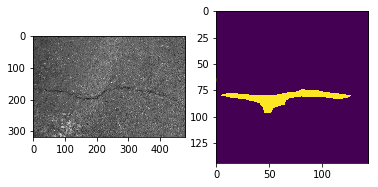

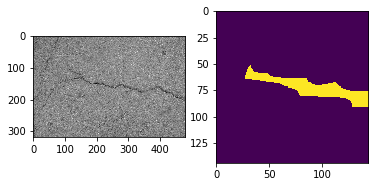

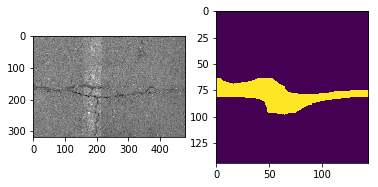

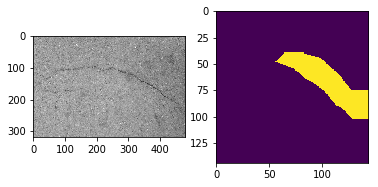

In [81]:
#pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\test\\*')

for y,pic in zip(pred_y,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = np.mean(y)
    std = np.std(y)
    y1 =  (y - mean) / std
    #y2 = cv2.normalize(y,y1,0,1,cv2.NORM_MINMAX)
    y1[y1 < 1.7] = 0
    y1[y1 > 1.7] = 1
    test = y1.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

# min-max normalization

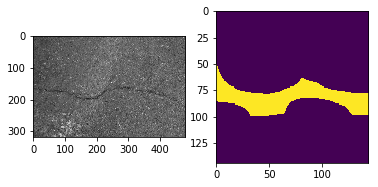

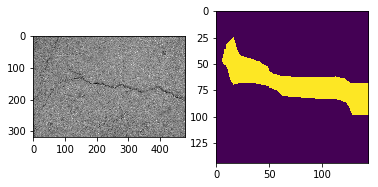

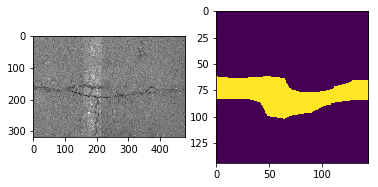

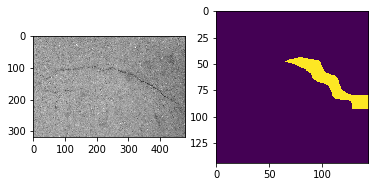

In [77]:
#pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\test\\*')

for y,pic in zip(pred_y,pics):
    a = cv2.imread(pic)
    y2 = np.zeros_like(y)
    mean = np.mean(y)
    std = np.std(y)
    y1 =  (y - mean) / std
    y2 = cv2.normalize(y1,y2,0,1,cv2.NORM_MINMAX)
    #y1[y1 < 1.8] = 0
    #y1[y1 > 1.8] = 1
    y2[y2 < 0.85] = 0
    y2[y2 > 0.85] = 1
    test = y2.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

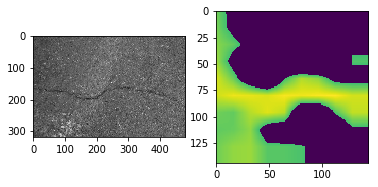

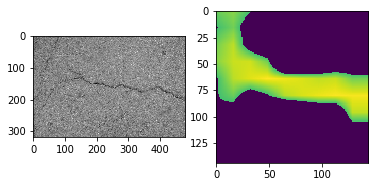

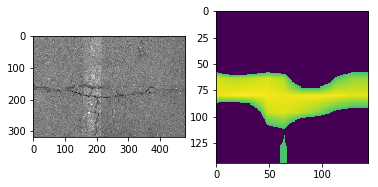

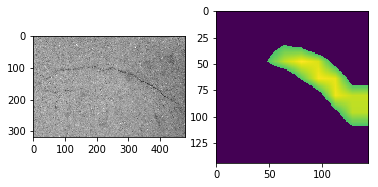

In [101]:
pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\test\\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    y[y < 0.7] = 0
    y[y > 1] = 1
    test = y.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

# final result   brighter lines indicate higher probability

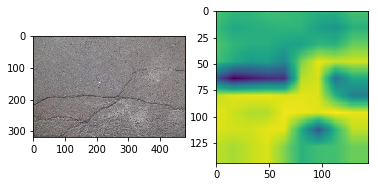

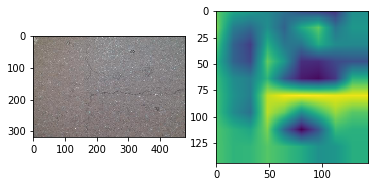

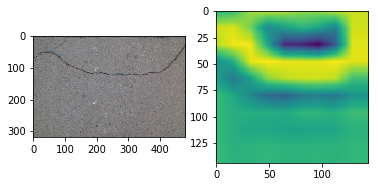

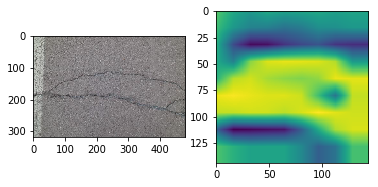

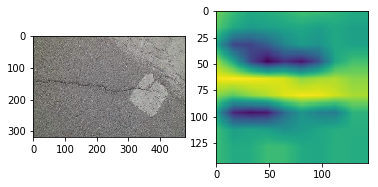

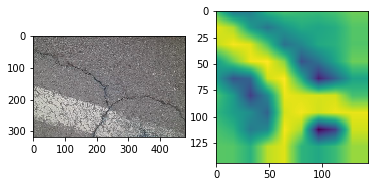

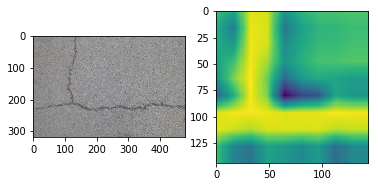

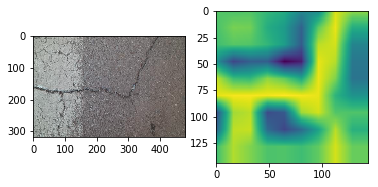

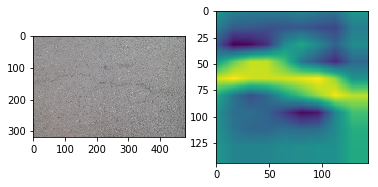

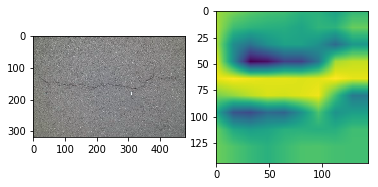

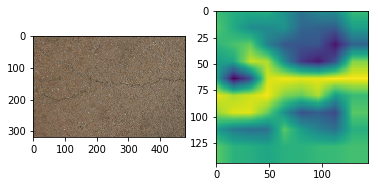

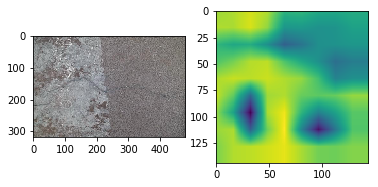

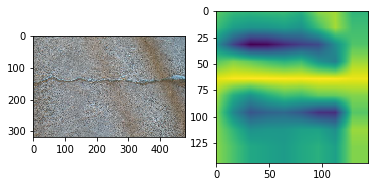

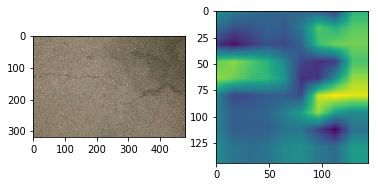

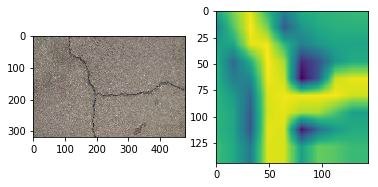

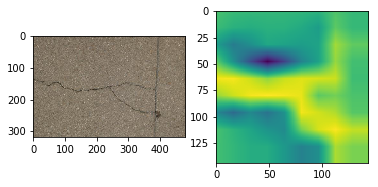

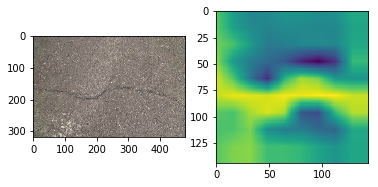

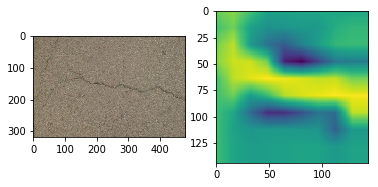

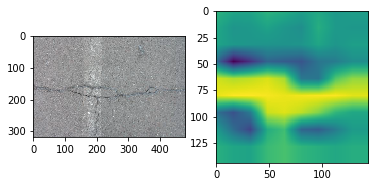

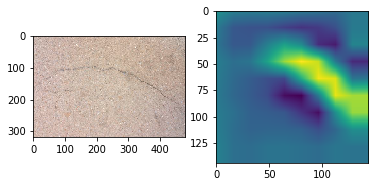

In [104]:
import cv2
import glob
import numpy

test_pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
   # y[y < 0.7] = 0
    #y[y > 1] = 1
    test = y.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

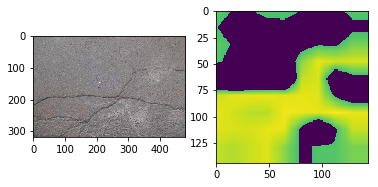

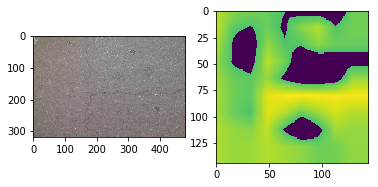

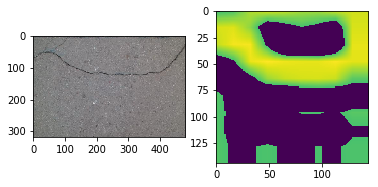

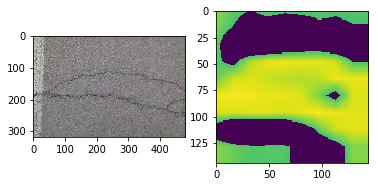

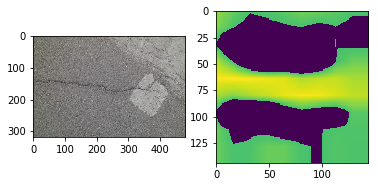

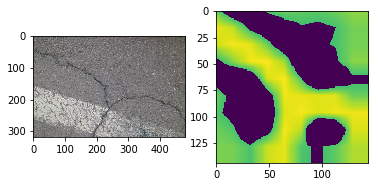

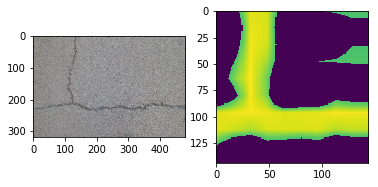

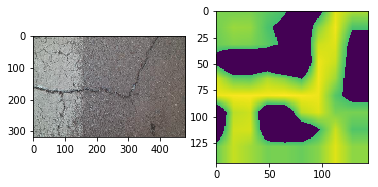

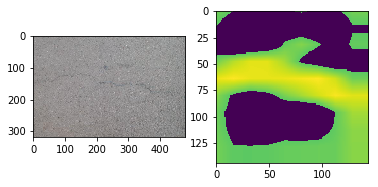

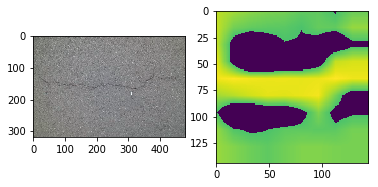

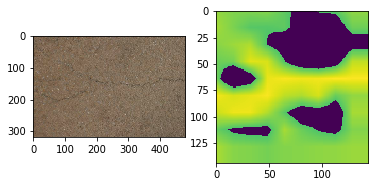

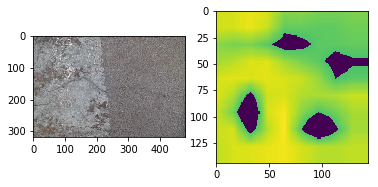

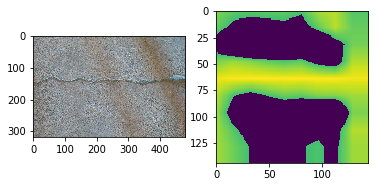

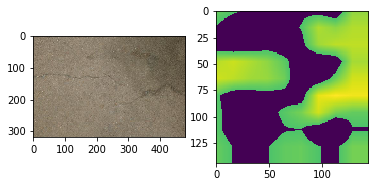

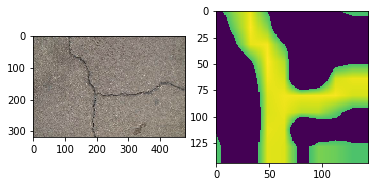

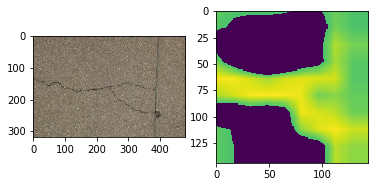

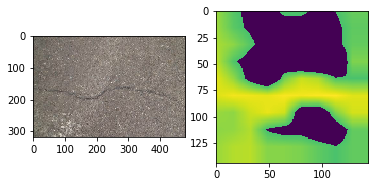

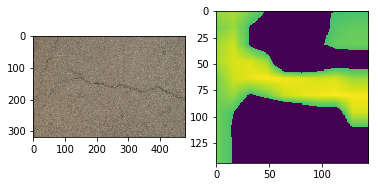

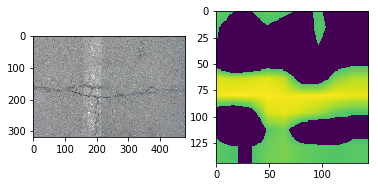

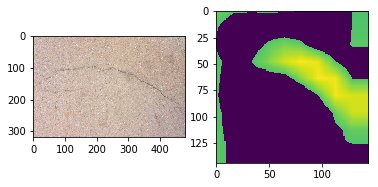

In [113]:
import cv2
import glob
import numpy

test_pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    y[y < 0.7] = 0
    y[y >= 1] = 1
    test = y.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

# batch normalization version (seems better than without BN)

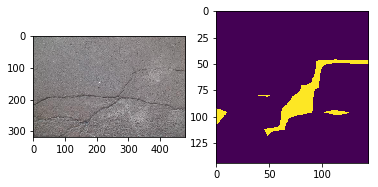

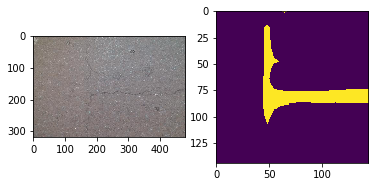

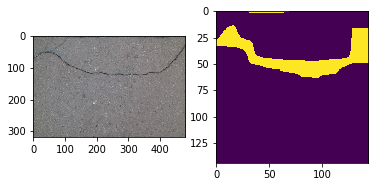

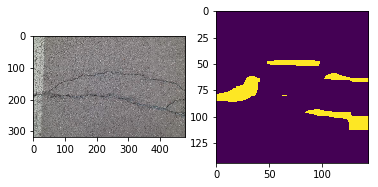

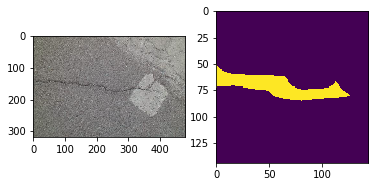

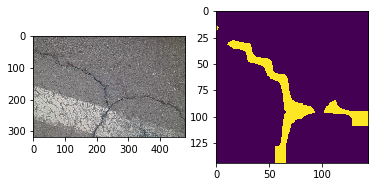

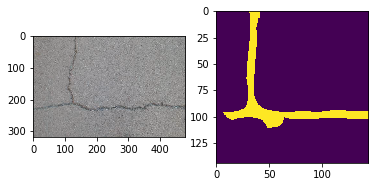

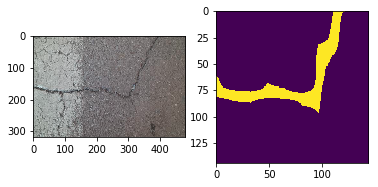

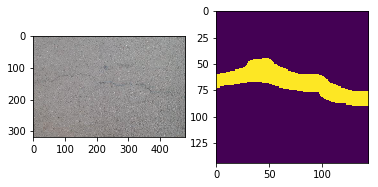

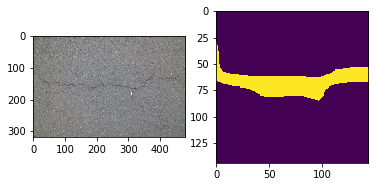

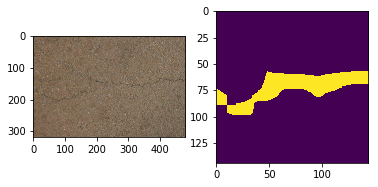

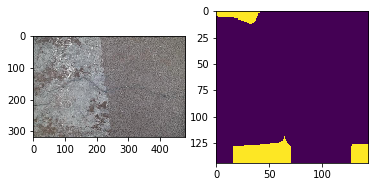

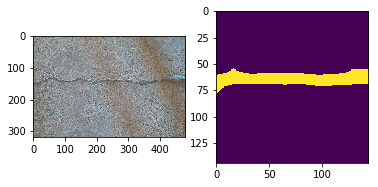

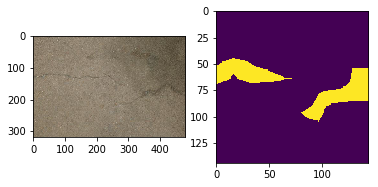

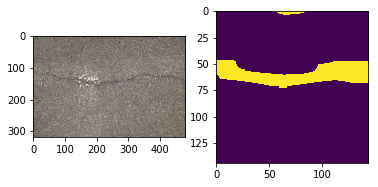

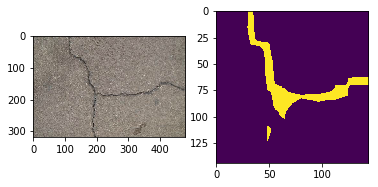

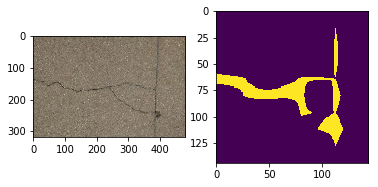

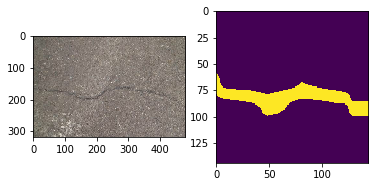

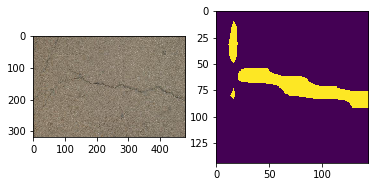

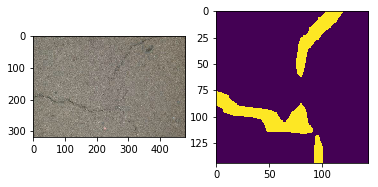

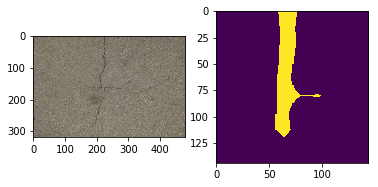

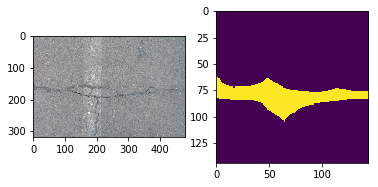

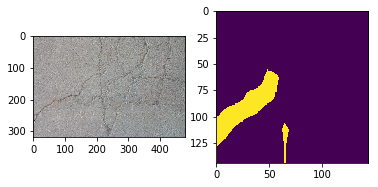

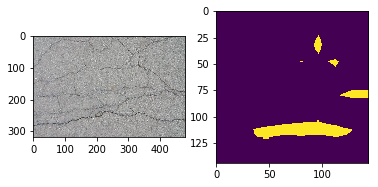

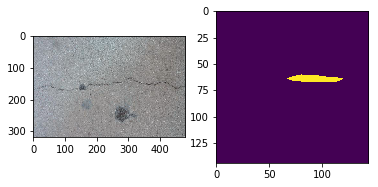

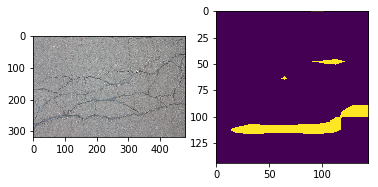

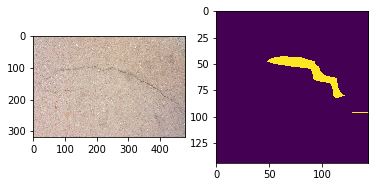

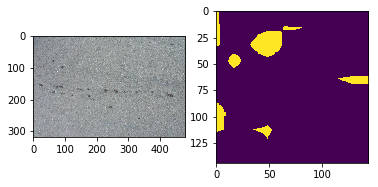

In [176]:
import cv2
import glob
import numpy

test_pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
pics = glob.glob('D:\\lizenan\\ground_crack_samples\\ground_crack_samples\\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    #y[y < 0.80] = 0
    #y[y >= 0.80] = 1
    mean = y.mean()
    std = y.std()
    std_value = std*1.5
    y[y < mean+std_value] = 0
    y[y >= mean+std_value] = 1
    test = y.reshape(144,144)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

In [1]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.engine import Layer
from keras.applications.vgg16 import *
from keras.models import *
import keras.backend as K
import tensorflow as tf
import cv2
import numpy as np
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN, TensorBoard, EarlyStopping
from keras.optimizers import Adam
def crop( o1 , o2 , i  ):
    o_shape2 = Model( i  , o2 ).output_shape
    outputHeight2 = o_shape2[1]
    outputWidth2 = o_shape2[2]

    o_shape1 = Model( i  , o1 ).output_shape
    outputHeight1 = o_shape1[1]
    outputWidth1 = o_shape1[2]

    cx = abs( outputWidth1 - outputWidth2 )
    cy = abs( outputHeight2 - outputHeight1 )

    if outputWidth1 > outputWidth2:
        o1 = Cropping2D( cropping=((0,0) ,  (  0 , cx ))  )(o1)
    else:
        o2 = Cropping2D( cropping=((0,0) ,  (  0 , cx )) )(o2)
    
    if outputHeight1 > outputHeight2 :
        o1 = Cropping2D( cropping=((0,cy) ,  (  0 , 0 ))  )(o1)
    else:
        o2 = Cropping2D( cropping=((0, cy ) ,  (  0 , 0 )) )(o2)

    return o1 , o2 

weight_decay = 0.
classes = 1
input_shape = (150,150,1)
img_input = Input(shape=input_shape)
image_size = input_shape[0:2]

# Block 1
x = Conv2D(64, (3, 3), padding='same',kernel_initializer='he_normal', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid',name='block1_pool')(x)
f1 = x

# Block 2
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3),  padding='same', kernel_initializer='he_normal',name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name='block2_pool')(x)
f2 = x

# Block 3
x = Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3),  padding='same', kernel_initializer='he_normal',name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block3_pool')(x)
f3 = x

# Block 4
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block4_pool')(x)


# Convolutional layers transfered from fully-connected layers
x = Conv2D(4096, (5, 5), padding='same', kernel_initializer='he_normal',name='fc1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Conv2D(2048, (1, 1), padding='same', kernel_initializer='he_normal',name='fc2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
#classifying layer
x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('linear')(x)
#x = BilinearUpSampling2D(size=(16, 16))(x)

#x = Conv2D(classes, (1, 1),
#               padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(weight_decay),
#               use_bias=False)(x)

x = Conv2DTranspose( classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(x)

x2 = f3

x2 = ( Conv2D( classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal' ))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('linear')(x2)

x , x2 = crop( x , x2 , img_input )

x = Add()([x,x2])

x = Conv2DTranspose( classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(x)

x2 = f2

x2 = ( Conv2D( classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal' ))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('linear')(x2)

x , x2 = crop( x , x2 , img_input )

x = Add()([x,x2])

x = Conv2DTranspose( classes , kernel_size=(8,8) ,  strides=(4,4) , use_bias=False )(x)

x = Cropping2D(cropping = ((0,2),(0,2)))(x)



#x = BatchNormalization()(x)
#x = Activation('linear')(x)

row, col, channel = input_shape

# TODO(ahundt) this is modified for the sigmoid case! also use loss_shape
x = Reshape((-1,))(x)
#x = Flatten()(x)
model = Model(img_input, x)
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block1_con

In [2]:
model.load_weights('D:\\lizenan\\weights_epoch=09-val_loss=0.0726.hdf5')

In [101]:
y_true = []
for gt in gts:
    mat_contents = sio.loadmat(gt)
    seg_mask = mat_contents['groundTruth'][0][0][0]-1
    seg_mask[seg_mask>0] = 1
    seg_mask[seg_mask<=0] = 0
    seg_mask = cv2.resize(seg_mask,(150,150))
    seg_mask = seg_mask.reshape(150,150,1)
    y_true += [seg_mask]
a = np.array(y_true)

# new final result

In [189]:
gts = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\groundTruth\*')
y_true = []
for gt in gts:
    mat_contents = sio.loadmat(gt)
    seg_mask = mat_contents['groundTruth'][0][0][0]-1
    #seg_mask[seg_mask>0] = 1
    #seg_mask[seg_mask<=0] = 0
    seg_mask = cv2.resize(seg_mask,(150,150))
    seg_mask = seg_mask.reshape(-1)
    y_true += [seg_mask]
y_true = np.array(y_true)

In [198]:
y_true.shape,np.where(y_true==2)[0]

((118, 22500), array([ 39,  53,  53, ..., 117, 117, 117], dtype=int64))

In [167]:
import cv2
import glob
import numpy
import matplotlib.pyplot as plt
import scipy.io as sio

def calc_precision_recall(ytrue, ypred):
    accuracy = len(np.where((ytrue==ypred))[0])/(ytrue.shape[0]*ytrue.shape[1])
    true_pos = len(np.where((ytrue==ypred)&(ytrue==1))[0])
    true_neg = len(np.where((ytrue==ypred)&(ytrue==0))[0])
    false_pos = len(np.where((ytrue!=ypred)&(ytrue==1))[0])
    false_neg = len(np.where((ytrue!=ypred)&(ytrue==0))[0])
    precision = float(true_pos)/(true_pos+false_pos)
    recall = float(true_pos)/(true_pos+false_neg)
    F1 = float(2*precision*recall)/(precision+recall)
    return accuracy, precision, recall, F1

test_pics = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\image\\*')
gts = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\groundTruth\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
y_true = []
for gt in gts:
    mat_contents = sio.loadmat(gt)
    seg_mask = mat_contents['groundTruth'][0][0][0]-1
    seg_mask[seg_mask>0] = 1
    seg_mask[seg_mask<=0] = 0
    seg_mask = cv2.resize(seg_mask,(150,150))
    seg_mask = seg_mask.reshape(150,150,1)
    y_true += [seg_mask]
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
y_true = np.array(y_true)
#print(y_true.shape)
pics = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\image\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
pred_y_bn_1 = pred_y_bn.copy()
pred_y_bn_2 = []
#print(pred_y_bn.min(),pred_y_bn.max())
for y_1 in pred_y_bn_1:
    mean = y_1.mean()
    std = y_1.std()
    std_value = std*2.6
    y_1[y_1 < mean+std_value] = 0
    y_1[y_1 >= mean+std_value] = 1
    pred_y_bn_2 += [y_1]
pred_y_bn_2 = np.array(pred_y_bn_2)
y_true_1 = y_true.reshape(-1,22500)
accuracy, precision, recall, F1 = calc_precision_recall(y_true_1, pred_y_bn_2)
"""
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = y.mean()
    std = y.std()
    std_value = std*2.6
    y[y < mean+std_value] = 0
    y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()
"""
print("accuracy: ",accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("F1: ", F1)

accuracy:  0.9667242937853108
precision:  0.31022104981968746
recall:  0.28319083108530324
F1:  0.29609032021608017


# visualize results 

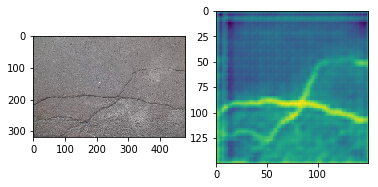

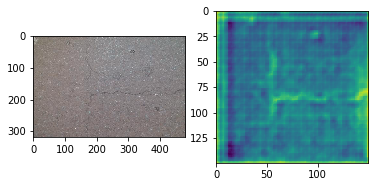

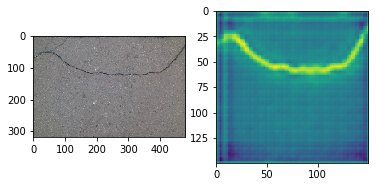

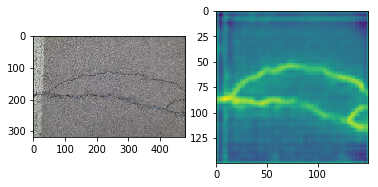

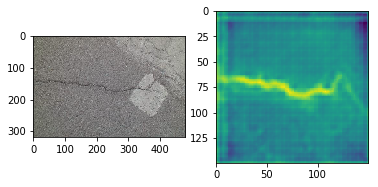

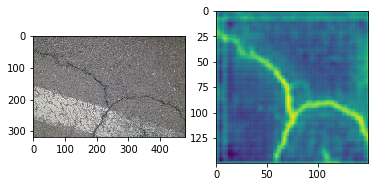

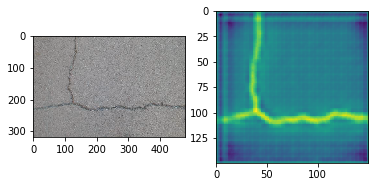

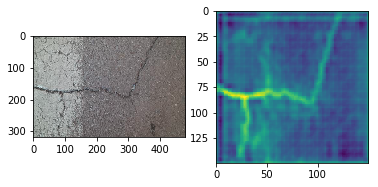

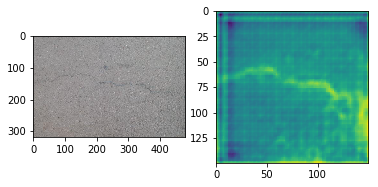

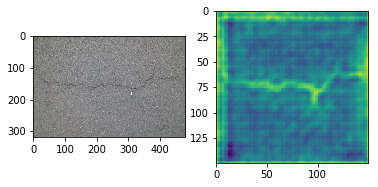

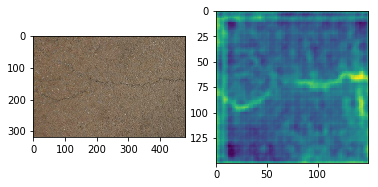

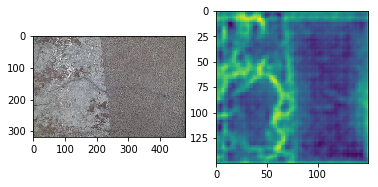

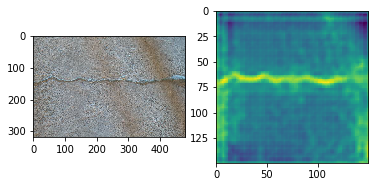

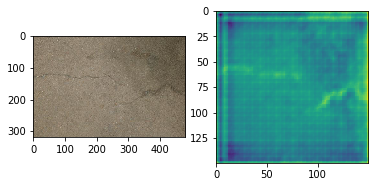

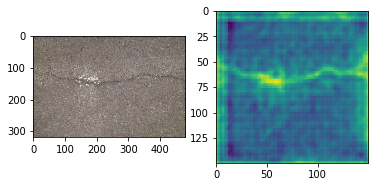

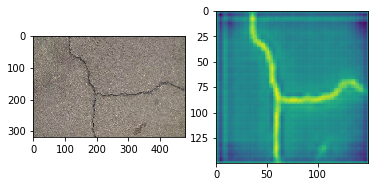

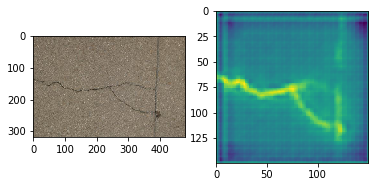

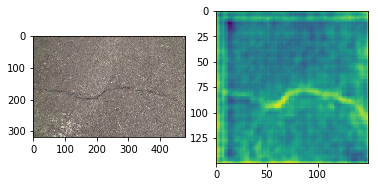

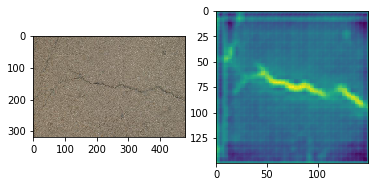

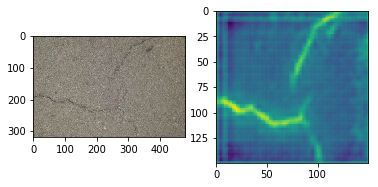

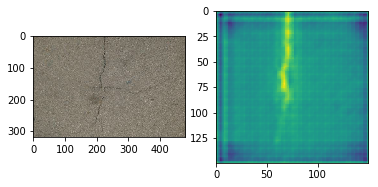

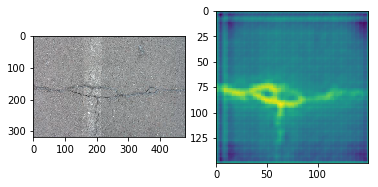

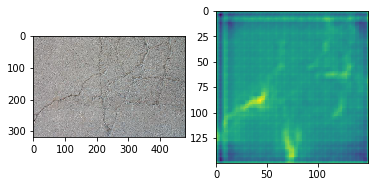

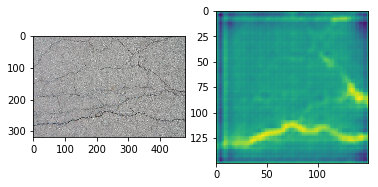

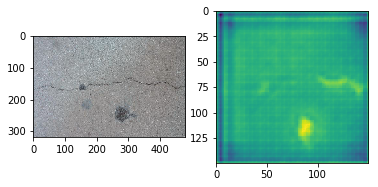

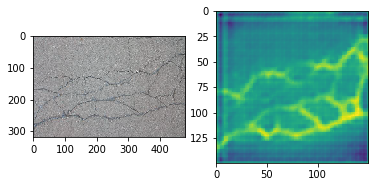

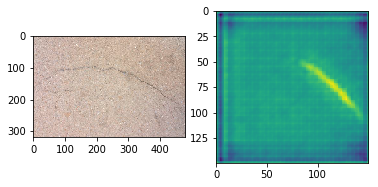

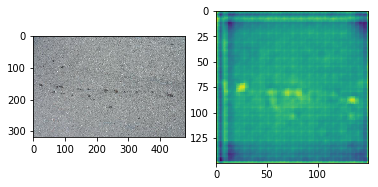

In [165]:


test_pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\*')


for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    #mean = y.mean()
    #std = y.std()
    #std_value = std*1.2
    #y[y < mean+std_value] = 0
    #y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()


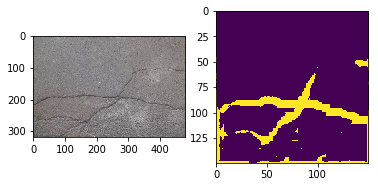

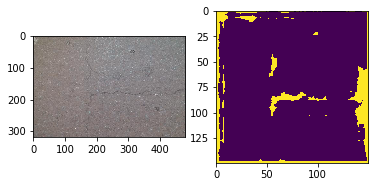

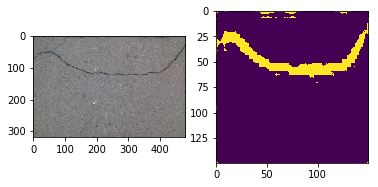

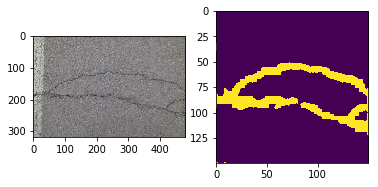

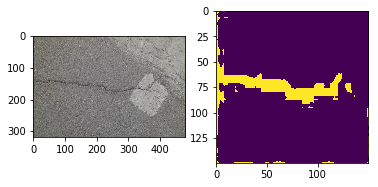

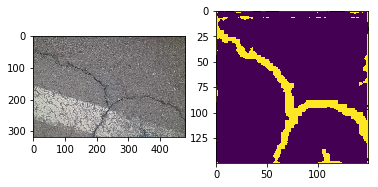

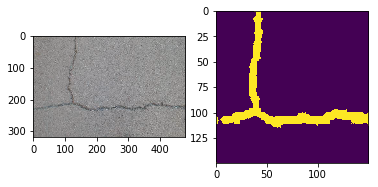

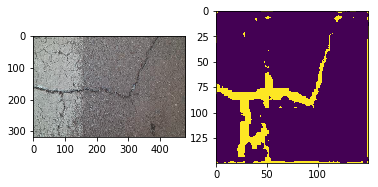

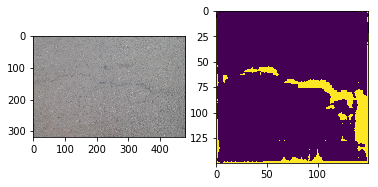

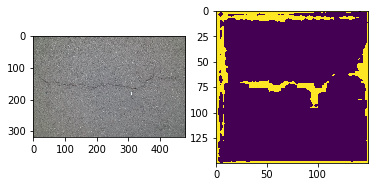

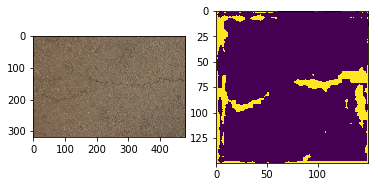

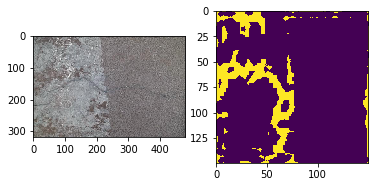

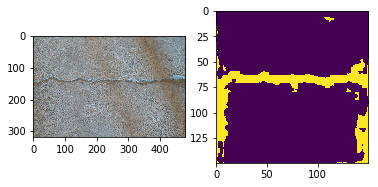

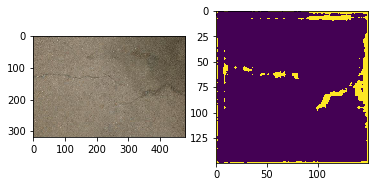

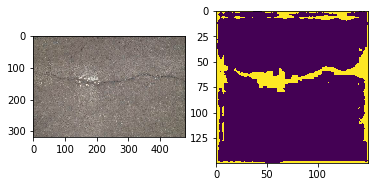

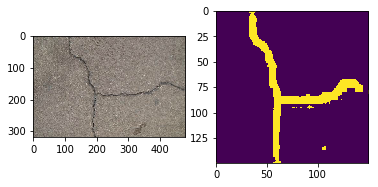

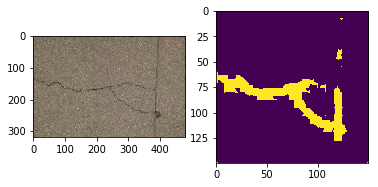

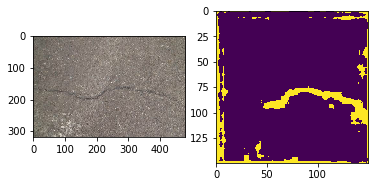

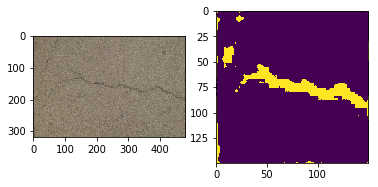

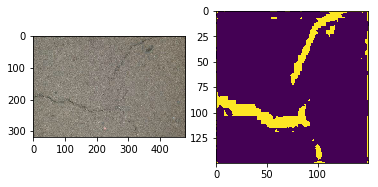

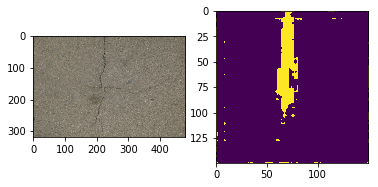

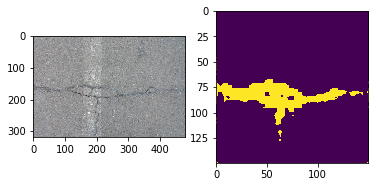

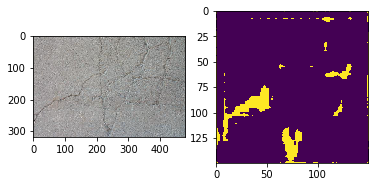

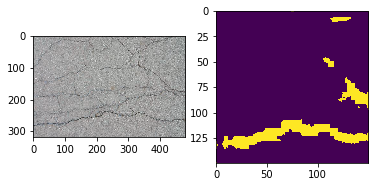

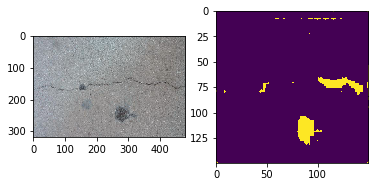

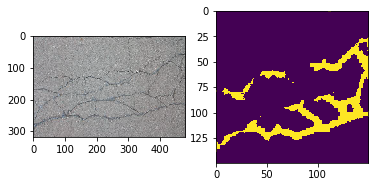

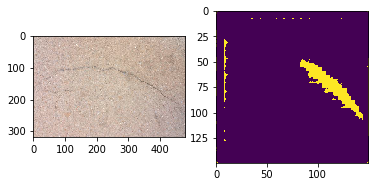

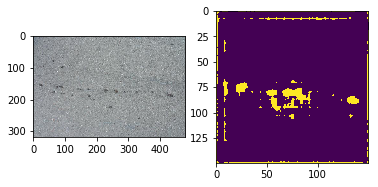

In [163]:

test_pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
#y_true = np.array(y_true)
#print(y_true.shape)
pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\*')
pred_y2 = np.zeros_like(pred_y)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
pred_y_bn_1 = pred_y_bn.copy()
pred_y_bn_2 = []


for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = y.mean()
    std = y.std()
    std_value = std*1.2
    y[y < mean+std_value] = 0
    y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()
